# Movie Sentiment Analysis

## Prep for analysis

In [1]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import collections

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hyper10n\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hyper10n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
reviews_path = r'../data/IMDB Dataset.csv'

In [3]:
reviews = pd.read_csv(reviews_path)

## Describe the data

In [4]:
reviews.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
reviews['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
reviews.shape

(50000, 2)

In [7]:
reviews.nunique()

review       49582
sentiment        2
dtype: int64

### Duplicate Reviews present
#### 50,000 rows but only 49,582 unique rows

## Clean dataset

### Remove any blanks

In [8]:
blanks = []
for i, review, label in reviews.itertuples():
    if review.isspace():
        blanks.append(i)
blanks

[]

#### No blank reviews

### Remove Duplicates

In [9]:
reviews.drop_duplicates(keep='first', inplace=True)

In [10]:
reviews.shape

(49582, 2)

### Text Processing

In [11]:
def clean_html(html):
    soup = BeautifulSoup(html, "html.parser")
    
    for data in soup(['br', 'i']):
        data.decompose()
    
    return ' '.join(soup.stripped_strings)

In [12]:
def remove_stopwords(text):
    text = text.split()
    stop_words = nltk.corpus.stopwords.words("english")
    stop_words = stop_words + ['movie', 'film']
    
    text_filtered = [word for word in text if not word in stop_words]
    return ' '.join(text_filtered)

In [13]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
reviews['review'] = reviews['review'].apply(clean_html)

In [53]:
sample_review = "<br /><br />As a Harold Lloyd fan, i agree with the other reviewer's comments, EXCEPT that I feel that \"Movie Crazy\" was his best sound film; \"Cat's Paw\" is a close second. (But, this is just MY opinion).<br /><br />This film is a \"hoot\" from beginning to end and, in many scenes, George Barbier (the crook that gets him elected mayor) almost steals the show! (Especially at the end of the film).<br /><br />One wishes that Una Merkel's character would be a bit more sympathetic to Harold, especially as the film progresses. Only in the last few minutes of the film do we find out her true feelings for him. (And, even then, there is no \"romance\" - kissing, etc).<br /><br />This is a Must-See film!"
sample_review

'<br /><br />As a Harold Lloyd fan, i agree with the other reviewer\'s comments, EXCEPT that I feel that "Movie Crazy" was his best sound film; "Cat\'s Paw" is a close second. (But, this is just MY opinion).<br /><br />This film is a "hoot" from beginning to end and, in many scenes, George Barbier (the crook that gets him elected mayor) almost steals the show! (Especially at the end of the film).<br /><br />One wishes that Una Merkel\'s character would be a bit more sympathetic to Harold, especially as the film progresses. Only in the last few minutes of the film do we find out her true feelings for him. (And, even then, there is no "romance" - kissing, etc).<br /><br />This is a Must-See film!'

In [71]:
def clean_single_review(review):
    partially_clean = remove_stopwords(clean_html(sample_review.lower()))
    clean_split = partially_clean.split()
    cleaned_text = []
    for word in partially_clean.split():
        cleaned_text.append(re.sub('[^a-zA-Z]', '', word))
    clean = ' '.join(cleaned_text)
    return clean

clean_single_review(sample_review)

'harold lloyd fan agree reviewers comments except feel movie crazy best sound film cats paw close second but opinion hoot beginning end and many scenes george barbier the crook gets elected mayor almost steals show especially end film one wishes una merkels character would bit sympathetic harold especially progresses last minutes find true feelings him and even then romance  kissing etc mustsee film'

In [15]:
reviews['normed_review'] = reviews['review'].str.lower()

In [16]:
reviews['normed_review'] = reviews['normed_review'].apply(remove_stopwords)

In [17]:
reviews['normed_review'] = reviews['normed_review'].apply(lambda x: ' '.join([re.sub('[^a-zA-Z]', '', word) for word in x.split()]))

## Visualize the dataset

### Prep for visualization

In [18]:
reviews['words'] = reviews['review'].str.split()
reviews['word_count'] = reviews['words'].apply(len)
reviews.drop('words', axis=1, inplace=True)

In [19]:
pos_reviews = reviews[reviews['sentiment'] == 'positive']
neg_reviews = reviews[reviews['sentiment'] == 'negative']

In [20]:
pos_reviews.shape

(24884, 4)

In [21]:
neg_reviews.shape

(24698, 4)

#### Average review length around 200 words

In [22]:
pos_reviews['word_count'].describe()

count    24884.000000
mean       230.861959
std        175.940775
min         10.000000
25%        124.000000
50%        171.000000
75%        281.000000
max       2459.000000
Name: word_count, dtype: float64

In [23]:
neg_reviews['word_count'].describe()

count    24698.000000
mean       227.242894
std        163.340692
min          4.000000
25%        127.000000
50%        173.000000
75%        275.750000
max       1491.000000
Name: word_count, dtype: float64

#### Positive reviews generally longer (compare final quartiles for each category)

In [24]:
def gen_word_dict(text):
    word_dict = {}
    for word in text.split():
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [25]:
pos_reviews['word_dict'] = pos_reviews['normed_review'].apply(gen_word_dict)
neg_reviews['word_dict'] = neg_reviews['normed_review'].apply(gen_word_dict)

In [26]:
def top_n_words(word_dict, n=10):
    d = collections.Counter(word_dict)
    return d.most_common(n)

In [27]:
pos_reviews['top_words'] = pos_reviews['word_dict'].apply(top_n_words, n=10)
neg_reviews['top_words'] = neg_reviews['word_dict'].apply(top_n_words, n=10)

In [28]:
def return_zero():
    return 0

pos_Cdict = collections.defaultdict(return_zero)
neg_Cdict = collections.defaultdict(return_zero)

for dictionary in pos_reviews['top_words']:
    for key, val in dictionary:
        pos_Cdict[key] += val
        
for dictionary in neg_reviews['top_words']:
    for key, val in dictionary:
        neg_Cdict[key] += val

In [29]:
overall_pos_word_count = collections.Counter(pos_Cdict)
overall_neg_word_count = collections.Counter(neg_Cdict)

top_pos_words = overall_pos_word_count.most_common(30)
top_neg_words = overall_neg_word_count.most_common(30)

top_words = top_pos_words + top_neg_words

In [30]:
pos_dict = dict(top_pos_words)
neg_dict = dict(top_neg_words)

In [31]:
pos_dict.values()

dict_values([15965, 8208, 6866, 5948, 5915, 4719, 4659, 4578, 4464, 4275, 4083, 3948, 3915, 3861, 3838, 3676, 3373, 3191, 3168, 3024, 3014, 2880, 2721, 2628, 2358, 2327, 2279, 2272, 2246, 2140])

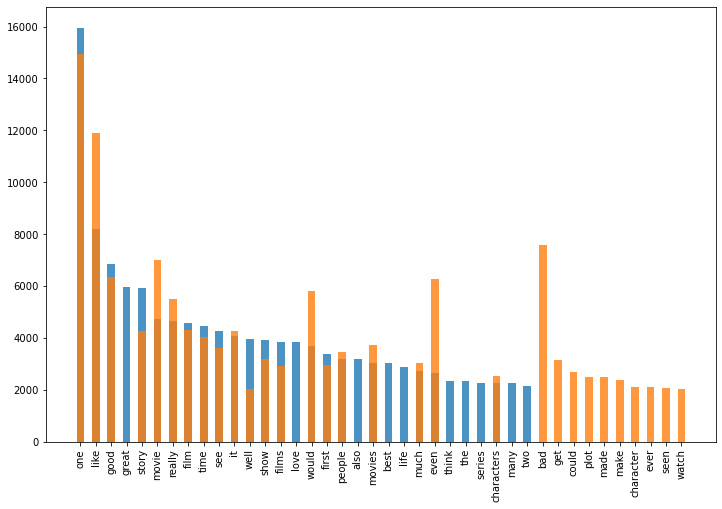

In [32]:
plt.figure(figsize=(12, 8))
plt.bar(*zip(*pos_dict.items()), width = 0.5, alpha=0.8)
plt.bar(*zip(*neg_dict.items()), width = 0.5, alpha = 0.8)
_ = plt.xticks(rotation='vertical')

## Machine Learning

In [33]:
sid = SentimentIntensityAnalyzer()

In [34]:
def score_sentiment(review, sid):
    score_dict = sid.polarity_scores(review)
    sentiment = ''
    if score_dict['compound'] > 0:
        sentiment = 'positive'
    else:
        sentiment = 'negative'
    
    return sentiment

In [47]:
review = 'This movie is great. I Love It!'
sentiment = score_sentiment(review, sid)

In [48]:
sentiment

'positive'

In [37]:
reviews['polarity'] = reviews['review'].apply(sid.polarity_scores)

In [38]:
reviews['prediction'] = reviews['polarity'].apply(lambda d:'positive' if d['compound'] > 0 else 'negative')

In [39]:
reviews.columns

Index(['review', 'sentiment', 'normed_review', 'word_count', 'polarity',
       'prediction'],
      dtype='object')

In [40]:
reviews['compound_score'] = reviews['polarity'].apply(lambda d: d['compound'])

<AxesSubplot:xlabel='word_count', ylabel='compound_score'>

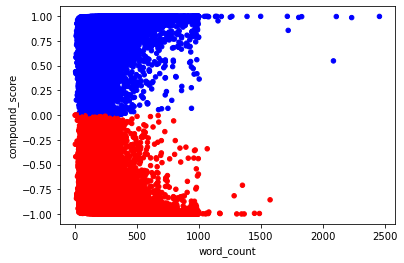

In [41]:
color_map = {'positive': 'b', 'negative': 'r'}
reviews.plot(x='word_count', y='compound_score', kind='scatter', color=reviews['prediction'].map(color_map))

## Model Assessment

In [42]:
print(classification_report(reviews['sentiment'], reviews['prediction']))

              precision    recall  f1-score   support

    negative       0.79      0.54      0.64     24698
    positive       0.65      0.86      0.74     24884

    accuracy                           0.70     49582
   macro avg       0.72      0.70      0.69     49582
weighted avg       0.72      0.70      0.69     49582



In [43]:
print(confusion_matrix(reviews['sentiment'], reviews['prediction']))

[[13290 11408]
 [ 3552 21332]]


#### VADER model had a significantly harder time predicting negative reviews

## Final Visual Analytics

In [44]:
pos_text = " ".join(review for review in pos_reviews['normed_review'])
neg_text = " ".join(review for review in neg_reviews['normed_review'])

stopwords = set(STOPWORDS)

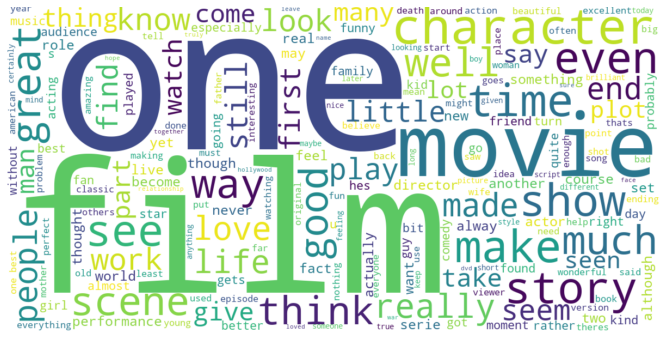

In [45]:
pos_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(pos_text)
plt.figure(figsize=(12, 6))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

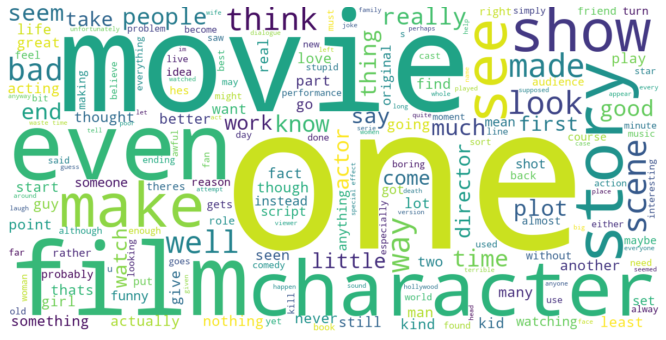

In [46]:
neg_wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(neg_text)
plt.figure(figsize=(12, 6))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()